# RNAseq data analysis

### Standard imports

In [142]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_curve, balanced_accuracy_score
from sklearn import metrics
from sklearn.decomposition import PCA
import scipy
import random
import collections
import csv

***Import Data***

In [126]:
df_tpm = pd.read_csv('data/gene_expression/MMRF_CoMMpass_IA9_E74GTF_Salmon_entrezID_TPM_hg19.csv', index_col=False)
df_counts = pd.read_csv('data/gene_expression/MMRF_CoMMpass_IA9_E74GTF_Salmon_Gene_Counts.txt',
                        delimiter = "\t")
df_clin = pd.read_csv('data/clinical/sc3_Training_ClinAnnotations.csv')

df_tpm.shape, df_counts.shape

((24128, 735), (57997, 735))

In [127]:
print("We have {} genes in the raw counts gene expression matrix".format(df_counts['GENE_ID'].unique().shape[0]))
print("We have {} genes in the raw counts gene expression matrix".format(df_tpm['Unnamed: 0'].unique().shape[0]))

We have 57997 genes in the raw counts gene expression matrix
We have 24128 genes in the raw counts gene expression matrix


In [128]:
print("N° of patients in the MMRF cohort, with RNAseq available RNA-seq data: {}".format(df_counts.shape[1]))
print("N° of patients in the MMRF cohort, with RNAseq available TPM-normalized RNA-seq data: {}".format(df_tpm.shape[1]))

N° of patients in the MMRF cohort, with RNAseq available RNA-seq data: 735
N° of patients in the MMRF cohort, with RNAseq available TPM-normalized RNA-seq data: 735


### Exploratory graphical analysis

**Gene Density plots**

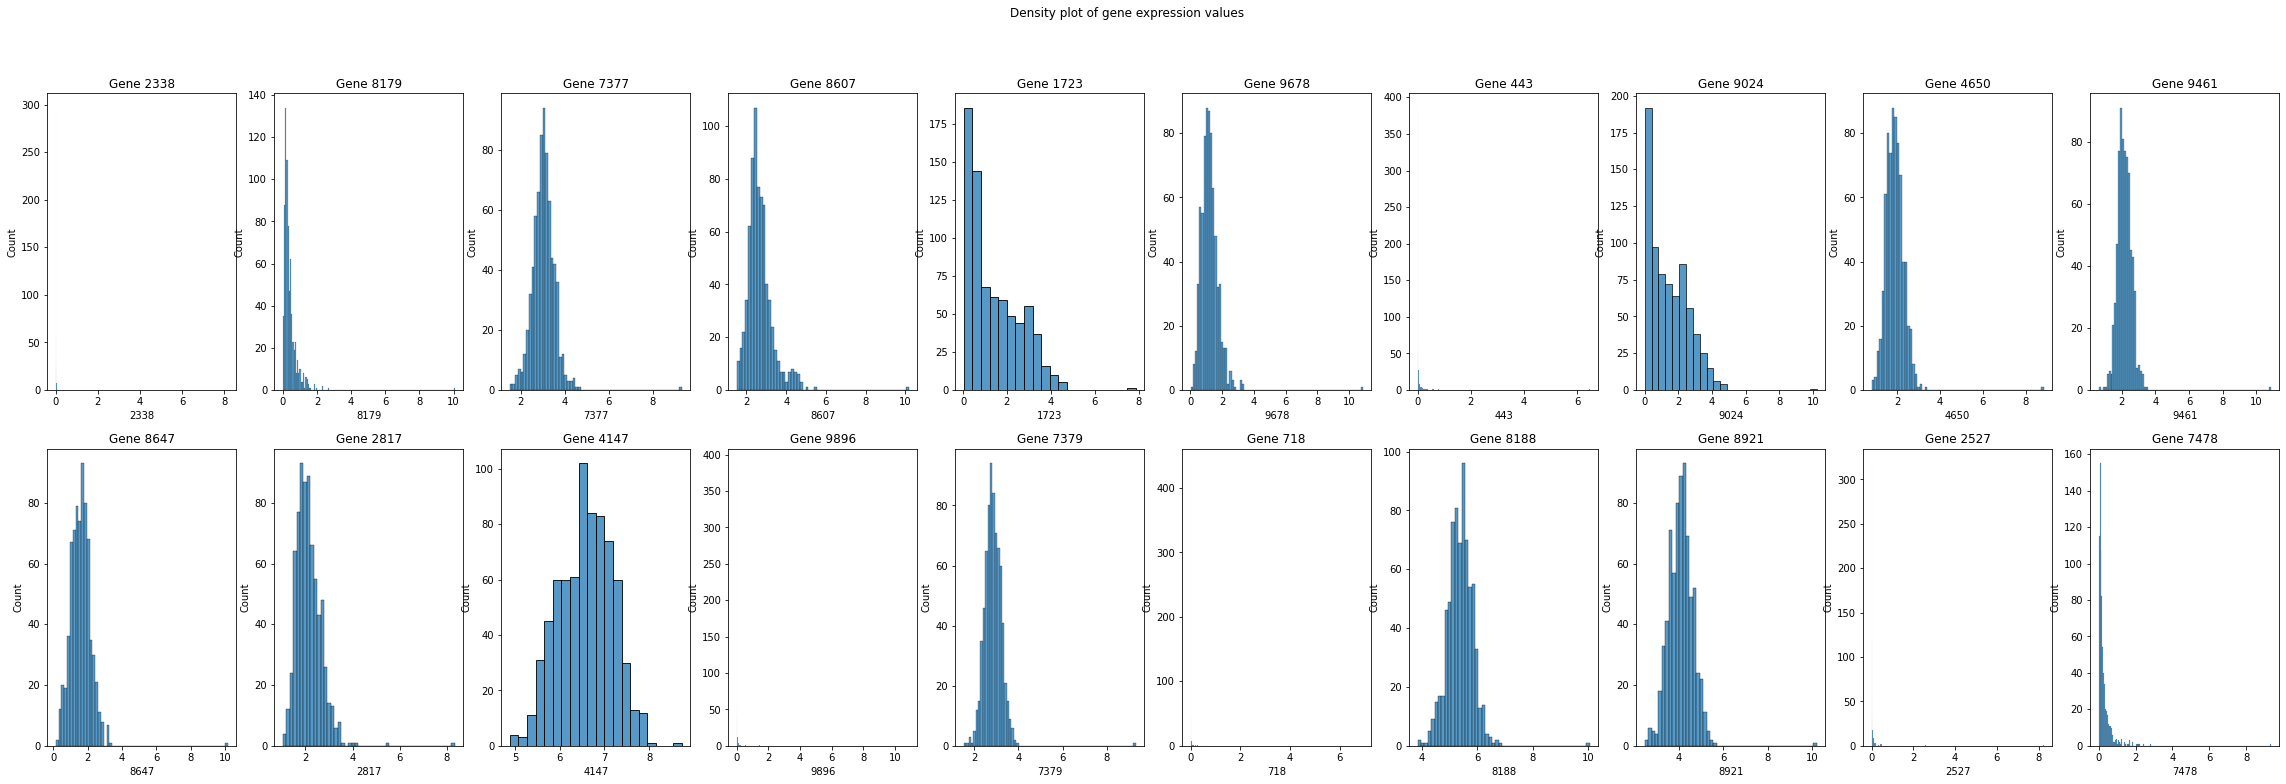

In [129]:
import random
import seaborn as sns

n_samples = 20
idx = random.sample(range(1, 10000), n_samples)
n_rows = 2
n_cols = int(n_samples / 2)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(40, 12))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1

        sns.histplot(ax=ax[i][j], data=np.log(1 + df_tpm.loc[k, :]),
                    palette="Set2"
                   )
        ax[i][j].set_title('Gene ' + str(k))

fig.suptitle("Density plot of gene expression values")
plt.show()

## Gene-level variance

**Distribution of gene expression variance with respect to genes**

the vast majority of the genes are very poorly expressed with a quasi-null variance, we can filter out those genes

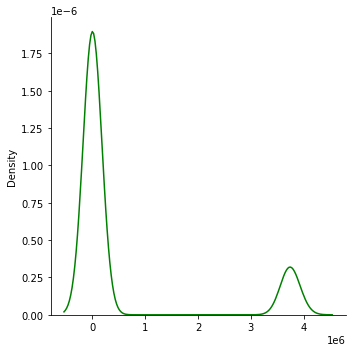

In [130]:
new_col = df_tpm.std(axis=1)
sns.displot(df_tpm.std(axis=1), kind='kde', color='green')

## DE preliminary analysis

While TPM and RPKM/FPKM normalization methods both account for sequencing depth and gene length, RPKM/FPKM are not recommended. The reason is that the normalized count values output by the RPKM/FPKM method are not comparable between samples.

### Sample level QC

A useful initial step in an RNA-seq analysis is often to assess overall similarity between samples:

Which samples are similar to each other, which are different?

Does this fit to the expectation from the experiment’s design?

What are the major sources of variation in the dataset?

**Gene filtering**

In [131]:
df_tpm['std'] = new_col
mean_var_thresh = df_tpm.std(axis=1).mean()
df_tpm = df_tpm[df_tpm['std'] > mean_var_thresh]

Log2-transformed normalized counts are used to assess similarity between samples using Principal Component Analysis (PCA) and hierarchical clustering. Using log2 transformation, tools aim to moderate the variance across the mean, thereby improving the distances/clustering for these visualization methods.

In [132]:
log_tpm = df_tpm.drop(['Unnamed: 0'], axis=1) 
log_tpm = np.log(1 + df_tpm)
log_tpm

,Unnamed: 0,MMRF_2490_1_BM,MMRF_2499_1_BM,MMRF_1089_1_BM,MMRF_1778_1_BM,MMRF_1777_1_BM,MMRF_1153_1_BM,MMRF_1392_1_BM,MMRF_1325_1_BM,MMRF_1846_1_BM,...,MMRF_1787_1_BM,MMRF_1048_1_BM,MMRF_2437_1_BM,MMRF_1242_5_BM,MMRF_1497_1_BM,MMRF_1380_2_BM,MMRF_1700_1_BM,MMRF_1918_1_BM,MMRF_1670_1_BM,std
20337,18.420778,1.592575,0.728548,0.897736,1.340978,0.576977,1.217725,1.111081,0.804782,1.776001,...,1.090718,1.209599,0.712808,1.660083,0.251197,0.961780,1.391416,1.142428,1.274387,15.120843
20338,18.421015,0.200626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.116269,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.121080
20339,18.421015,0.105336,0.000000,0.000000,0.402654,0.000000,0.000000,0.000000,0.000000,0.128806,...,0.116269,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.121080
20340,18.421015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054624,0.076996,0.000000,...,0.059823,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.121080
20341,18.421015,0.000000,0.000000,0.000000,0.048389,0.041680,0.000000,0.054624,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.121080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23985,18.431224,1.703495,0.995496,1.542778,1.238905,2.059604,1.450837,1.428209,1.391293,2.673370,...,0.992081,1.447296,1.390630,2.235768,1.522640,3.442469,0.851270,0.941941,1.264842,15.131289
23987,18.439781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.139846
23988,18.439789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.139854
23989,18.447556,1.064994,0.433564,0.042104,1.459362,0.462819,0.903491,0.964926,0.314406,0.172569,...,1.237175,0.541452,0.311677,0.344983,0.967144,0.945606,0.296103,1.166126,0.220615,15.147621


Randomly select a few patients and plot them.

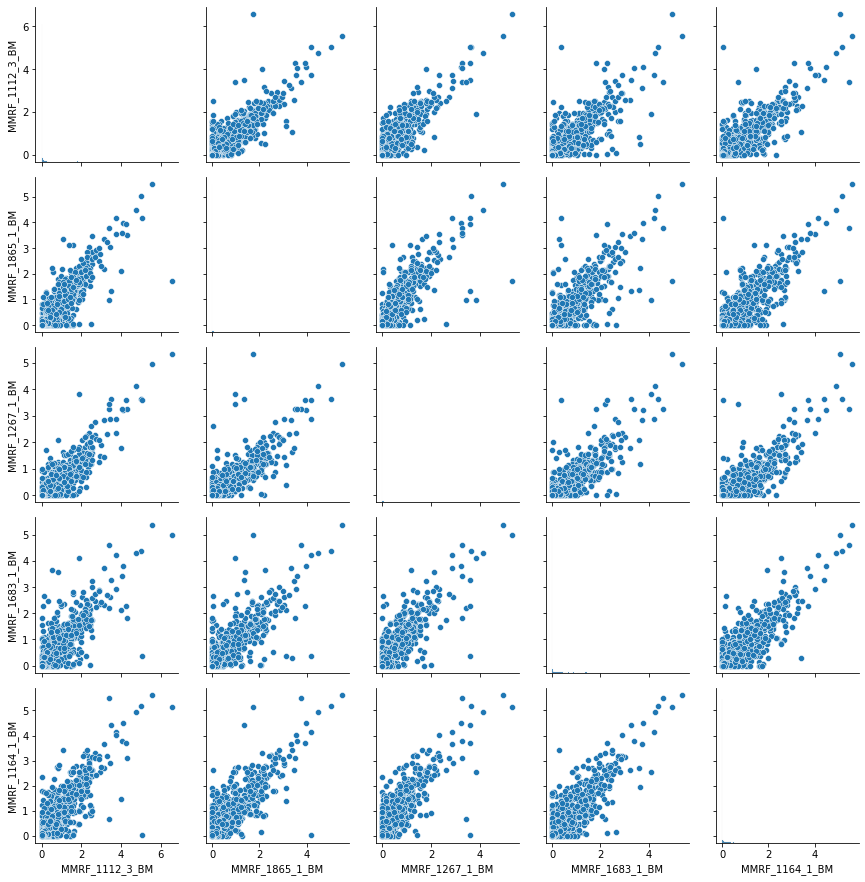

In [135]:
random_patients = random.sample(list(log_tpm.columns), 5)
g = sns.PairGrid(log_tpm.loc[:, random_patients])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

Sample-level QC allows us to see how well our replicates cluster together, as well as, observe whether our experimental condition represents the major source of variation in the data. Performing sample-level QC can also identify any sample outliers, which may need to be explored to determine whether they need to be removed prior to DE analysis.

### PCA for visualizing clusters

Let's visualize the distirbution of the standard deviations of the genese, post filtering

We have 3652 genes left in the dataset


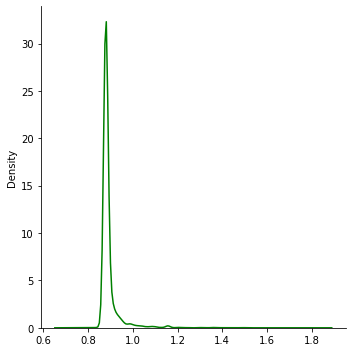

In [136]:
print("We have {} genes left in the dataset".format(log_tpm.shape[0]))
sns.displot(log_tpm.std(axis=1), kind='kde', color='green')

In [146]:
df_clin

,Study,Patient,D_Age,D_Gender,D_OS,D_OS_FLAG,D_PFS,D_PFS_FLAG,D_ISS,PatientType,...,CYTO_predicted_feature_10,CYTO_predicted_feature_11,CYTO_predicted_feature_12,CYTO_predicted_feature_13,CYTO_predicted_feature_14,CYTO_predicted_feature_15,CYTO_predicted_feature_16,CYTO_predicted_feature_17,CYTO_predicted_feature_18,HR_FLAG
0,MMRF,MMRF_1021,54,Female,1575,0,623,1,1.0,NewlyDiagnosed,...,0.0,NaN,0,0,0,0,0,0,0,FALSE
1,MMRF,MMRF_1029,46,Male,995,0,995,0,1.0,NewlyDiagnosed,...,NaN,NaN,0,0,0,0,0,0,0,FALSE
2,MMRF,MMRF_1030,65,Female,1572,0,1572,0,1.0,NewlyDiagnosed,...,NaN,NaN,0,0,0,1,0,0,0,FALSE
3,MMRF,MMRF_1031,62,Male,1581,0,1329,1,1.0,NewlyDiagnosed,...,NaN,NaN,0,0,0,0,0,0,0,FALSE
4,MMRF,MMRF_1032,76,Male,934,1,908,1,2.0,NewlyDiagnosed,...,NaN,NaN,0,0,0,0,0,0,0,FALSE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,MMRF,MMRF_2608,67,Male,335,0,335,0,1.0,NewlyDiagnosed,...,0.0,NaN,0,0,0,0,1,0,0,CENSORED
579,MMRF,MMRF_2611,66,Female,247,0,246,0,2.0,NewlyDiagnosed,...,NaN,NaN,0,1,0,0,0,1,0,CENSORED
580,MMRF,MMRF_2613,70,Female,253,0,253,0,2.0,NewlyDiagnosed,...,NaN,NaN,0,0,0,0,0,0,0,CENSORED
581,MMRF,MMRF_2614,58,Male,290,0,290,0,1.0,NewlyDiagnosed,...,NaN,NaN,1,0,0,0,1,0,0,CENSORED


In [141]:
metadata = {'Gender': df_clin["D_Gender"].values, 'HR': df_clin["HR_FLAG"]}
patient_to_g

In [144]:
X = log_tpm.drop(['std'], axis=1)

,Unnamed: 0,MMRF_2490_1_BM,MMRF_2499_1_BM,MMRF_1089_1_BM,MMRF_1778_1_BM,MMRF_1777_1_BM,MMRF_1153_1_BM,MMRF_1392_1_BM,MMRF_1325_1_BM,MMRF_1846_1_BM,...,MMRF_1787_1_BM,MMRF_1048_1_BM,MMRF_2437_1_BM,MMRF_1242_5_BM,MMRF_1497_1_BM,MMRF_1380_2_BM,MMRF_1700_1_BM,MMRF_1918_1_BM,MMRF_1670_1_BM,std
20337,18.420778,1.592575,0.728548,0.897736,1.340978,0.576977,1.217725,1.111081,0.804782,1.776001,...,1.090718,1.209599,0.712808,1.660083,0.251197,0.961780,1.391416,1.142428,1.274387,15.120843
20338,18.421015,0.200626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.116269,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.121080
20339,18.421015,0.105336,0.000000,0.000000,0.402654,0.000000,0.000000,0.000000,0.000000,0.128806,...,0.116269,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.121080
20340,18.421015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054624,0.076996,0.000000,...,0.059823,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.121080
20341,18.421015,0.000000,0.000000,0.000000,0.048389,0.041680,0.000000,0.054624,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.121080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23985,18.431224,1.703495,0.995496,1.542778,1.238905,2.059604,1.450837,1.428209,1.391293,2.673370,...,0.992081,1.447296,1.390630,2.235768,1.522640,3.442469,0.851270,0.941941,1.264842,15.131289
23987,18.439781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.139846
23988,18.439789,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.139854
23989,18.447556,1.064994,0.433564,0.042104,1.459362,0.462819,0.903491,0.964926,0.314406,0.172569,...,1.237175,0.541452,0.311677,0.344983,0.967144,0.945606,0.296103,1.166126,0.220615,15.147621


Find intersection of patients in clinical and sequencing data

In [171]:
clinical_patients = list(df_clin['Patient'] + '_1_BM')
seq_patients = list(log_tpm.drop(['Unnamed: 0', 'std'], axis=1).columns)

# find intersection
common_patients = list(set(seq_patients) & set(clinical_patients))
                    
len(common_patients)

582

select subset of common patients

In [178]:
df_log = log_tpm.loc[:, common_patients]

mapping

In [251]:
id_to_gender = {k: df_clin.loc[df_clin['Patient'] == k.split('_1_BM')[0]]['D_Gender'].values[0] for k in df_log.columns}
id_to_flag = {k: df_clin.loc[df_clin['Patient'] == k.split('_1_BM')[0]]['HR_FLAG'].values[0] for k in df_log.columns}
id_to_os = {k: df_clin.loc[df_clin['Patient'] == k.split('_1_BM')[0]]['D_OS_FLAG'].values[0] for k in df_log.columns}

In [252]:
X = df_log.values.T
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

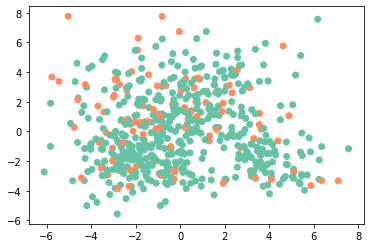

In [255]:
# Unique category labels: 'D', 'F', 'G', ...

dict_temp = id_to_os
#dict_temp = id_to_iss

color_labels = np.unique(list(dict_temp.values()))
# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# array of colors
colors = pd.Series(dict_temp.values())

# Plot
plt.scatter(X_pca[:, ],
            X_pca[:, 3], 
            c=colors.map(color_map), 
            )

plt.show()

### Prepare the data for Differential Expression with DESeq2 (in R)

**Remember**: For the training, we only care about patients that have RNA-seq data available

In [310]:
#print("List of patients that have RNA-seq data{}".format(common_patients))

#### Overlapping Genes

Patients of the validation set might come from different cohorts and we don't have the guarantee that the genes of these patients are the one in the training set: For the sake of robustness, we only care about **overlapping genes**.

In [312]:
### Overlapping genes
df_overlap = pd.read_csv("data/gene_expression/overlappingEntrezIds.csv")

print("Overlapping genes in all cohort studies{}".format(df_overlap))

Overlapping genes in all cohort studies       entrezID
0           100
1          1000
2         10000
3         10001
4         10003
...         ...
13732      9991
13733      9992
13734      9993
13735      9994
13736      9997

[13737 rows x 1 columns]


In [272]:
df_exp = df_counts[['GENE_ID'] + common_patients]
#df_exp.columns = ['GENE_ID'] + [common_patients]
df_exp

,GENE_ID,MMRF_1677_1_BM,MMRF_2526_1_BM,MMRF_1974_1_BM,MMRF_2307_1_BM,MMRF_1447_1_BM,MMRF_2384_1_BM,MMRF_1982_1_BM,MMRF_2002_1_BM,MMRF_2499_1_BM,...,MMRF_1178_1_BM,MMRF_1031_1_BM,MMRF_2316_1_BM,MMRF_2587_1_BM,MMRF_1931_1_BM,MMRF_2489_1_BM,MMRF_2150_1_BM,MMRF_2490_1_BM,MMRF_1700_1_BM,MMRF_1522_1_BM
0,ERCC-00170,0.000,0.00000,0.000,0.000,0.00000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000
1,ERCC-00168,0.000,0.00000,0.000,0.000,0.00000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000
2,ERCC-00165,0.000,0.00000,0.000,0.000,0.00000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000
3,ERCC-00163,0.000,0.00000,0.000,0.000,0.00000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000
4,ERCC-00157,0.000,0.00000,0.000,0.000,0.00000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57992,ENSG00000266285,0.000,4.21775,0.000,0.000,4.17917,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.35592
57993,ENSG00000161328,259.512,868.85600,334.543,323.323,355.22900,590.823,163.594,626.814,235.810,...,233.620,216.243,235.452,516.807,339.469,375.603,538.601,1145.740,710.167,570.84400
57994,ENSG00000102531,33758.200,10114.20000,13870.900,42458.800,22938.10000,10075.900,28455.400,21304.800,24747.500,...,13326.600,7290.290,18306.000,13284.600,29349.800,14746.400,8624.300,17935.800,9770.910,18177.50000
57995,ENSG00000225276,0.000,0.00000,0.000,0.000,0.00000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000


Create a metadata matrix for the DESeq2 analysis. This matrix should contain ..;

In [293]:
metadata_df = pd.DataFrame(columns = ["Patient", "D_Age", "D_ISS", "HR_FLAG"])
for i, patient_id in enumerate(df_exp.columns[1:]):
    patient = patient_id.split('_1_BM')[0]
    temp_df = df_clin[df_clin["Patient"] == patient]
    metadata_df.loc[i] = [patient_id, temp_df["D_Age"].values[0], temp_df["D_ISS"].values[0], temp_df["HR_FLAG"].values[0]]

missing values in D_ISS.

In [298]:
metadata_df["D_ISS"].fillna(2)

0      2.0
1      2.0
2      3.0
3      1.0
4      2.0
      ... 
577    1.0
578    2.0
579    3.0
580    3.0
581    2.0
Name: D_ISS, Length: 582, dtype: float64

In [295]:
df_exp

,GENE_ID,MMRF_1677_1_BM,MMRF_2526_1_BM,MMRF_1974_1_BM,MMRF_2307_1_BM,MMRF_1447_1_BM,MMRF_2384_1_BM,MMRF_1982_1_BM,MMRF_2002_1_BM,MMRF_2499_1_BM,...,MMRF_1178_1_BM,MMRF_1031_1_BM,MMRF_2316_1_BM,MMRF_2587_1_BM,MMRF_1931_1_BM,MMRF_2489_1_BM,MMRF_2150_1_BM,MMRF_2490_1_BM,MMRF_1700_1_BM,MMRF_1522_1_BM
0,ERCC-00170,0.000,0.00000,0.000,0.000,0.00000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000
1,ERCC-00168,0.000,0.00000,0.000,0.000,0.00000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000
2,ERCC-00165,0.000,0.00000,0.000,0.000,0.00000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000
3,ERCC-00163,0.000,0.00000,0.000,0.000,0.00000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000
4,ERCC-00157,0.000,0.00000,0.000,0.000,0.00000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57992,ENSG00000266285,0.000,4.21775,0.000,0.000,4.17917,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.35592
57993,ENSG00000161328,259.512,868.85600,334.543,323.323,355.22900,590.823,163.594,626.814,235.810,...,233.620,216.243,235.452,516.807,339.469,375.603,538.601,1145.740,710.167,570.84400
57994,ENSG00000102531,33758.200,10114.20000,13870.900,42458.800,22938.10000,10075.900,28455.400,21304.800,24747.500,...,13326.600,7290.290,18306.000,13284.600,29349.800,14746.400,8624.300,17935.800,9770.910,18177.50000
57995,ENSG00000225276,0.000,0.00000,0.000,0.000,0.00000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00000


Save data

In [306]:
df_exp.to_csv("data/gene_expression/differential_expression/count_gene_expression.csv")
metadata_df.to_csv("data/gene_expression/differential_expression/metadata.csv")

In [304]:
os.getcwd()

'/Users/khalilouardini/Desktop/Job Search/Owkin/MM_DREAM_Challenge/exploration'

## Adding genes from the litterature